### Imports

In [1]:
%load_ext PWE_NB_Extension

In [2]:
from PW_explorer.load_worlds import load_worlds
from PW_explorer.visualize import PWEVisualization
from PW_explorer.nb_helper import ASPRules
from PW_explorer.query import PWEQuery
from PW_explorer.helper import pw_slicer

In [3]:
import numpy as np
import os

In [4]:
import networkx as nx
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

##### Boring Boilerplate code

In [5]:
# Fixes positions of the nodes, so we get nicer looking outputs with consistent node placement.
def mod_g(g):
    g.nodes['a']['pos'] = '"1,2!"'
    g.nodes['b']['pos'] = '"2,1!"'
    g.nodes['c']['pos'] = '"2,3!"'
    g.nodes['d']['pos'] = '"3,1!"'
    g.nodes['e']['pos'] = '"3,3!"'
    g.nodes['f']['pos'] = '"4,2!"'
    return g

In [6]:
def get_vizs(exp, groups):
    vizs = {}
    for q_rels, group in groups.items():
        group_vizs = []
        for pw_id in group:
            temp_dfs, _ = pw_slicer(exp['pw_rel_dfs'], None, [pw_id])
            g = PWEVisualization.graphviz_from_meta_data(temp_dfs, exp['meta_data']['graphviz'])
            g = mod_g(g)
            group_vizs.append(g)
            #display(draw(g, layout='neato'))
        vizs[q_rels] = group_vizs
    return vizs

In [7]:
def save_vizs(vizs, folder_name):
    os.makedirs(folder_name, exist_ok=True)
    for i, (_, g_vizs) in enumerate(vizs.items()):
        if len(g_vizs) > 1:
            group_folder = "group_{}".format(str(i+1))
            os.makedirs(os.path.join(folder_name, group_folder), exist_ok=True)
            for j, g in enumerate(g_vizs):
                fname = 'ex_{}.{}'.format(str(j+1), 'png')
                draw(g, layout='neato', filename=os.path.join(folder_name, group_folder, fname))
        else:
            group_viz_name = 'group_{}.{}'.format(str(i+1), 'png')
            draw(g_vizs[0], layout='neato', filename=os.path.join(folder_name, group_viz_name))

# Transitive Closure

Let us consider a small graph.

In [8]:
%%dlv --donot-run -exp e1 --donot-display_input -lci g_e1

% A simple base graph:
% a ->  b -> d  
%  \     \    \
%   \->c  \->e-\->f

% graphviz graph graph_type=directed
% graphviz edge e(HEAD,TAIL) color=black ord=3

e(a,b). e(a,c).
e(b,d). e(b,e).
e(d,f). e(e,f).

In [9]:
%dlv --run -l g_e1 -exp e1 --donot-display_input 

Output:


'{e(a,b), e(a,c), e(b,d), e(b,e), e(d,f), e(e,f)}'

In [10]:
e1['pw_rel_dfs'], e1['rel_schemas'], e1['pw_objects'] = load_worlds(e1['asp_soln'], e1['meta_data'], reasoner='dlv')

Number of Models: 1


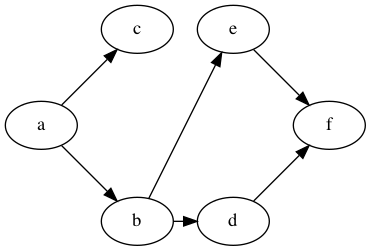

In [11]:
draw(mod_g(PWEVisualization.graphviz_from_meta_data(e1['pw_rel_dfs'], e1['meta_data']['graphviz'])), layout='neato')

### Transitive Closure Encoding

In [12]:
%%dlv --donot-run --donot-display_input -lci tc

% Playing with transitive closure and its provenance..

% Simple (right) recursive rules from computing the transitive closure tc of e:

% graphviz edge tc(HEAD,TAIL) color=blue ord=1
tc(X,Y) :- e(X,Y).
tc(X,Y) :- e(X,Z), tc(Z,Y).

Now we generate the tc/2 edges on the graph shown above.

In [13]:
%dlv --run -l g_e1 tc -exp tc_e1 --donot-display_input

Output:


'{e(a,b), e(a,c), e(b,d), e(b,e), e(d,f), e(e,f), tc(a,b), tc(a,c), tc(a,d), tc(a,e), tc(a,f), tc(b,d), tc(b,e), tc(b,f), tc(d,f), tc(e,f)}'

In [14]:
tc_e1['pw_rel_dfs'], tc_e1['rel_schemas'], tc_e1['pw_objects'] = load_worlds(tc_e1['asp_soln'], tc_e1['meta_data'], reasoner='dlv')

Number of Models: 1


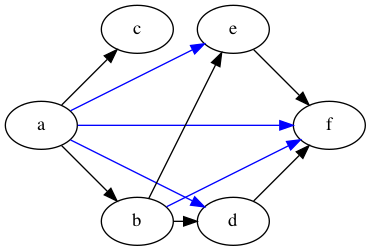

In [15]:
draw(mod_g(PWEVisualization.graphviz_from_meta_data(tc_e1['pw_rel_dfs'], tc_e1['meta_data']['graphviz'])), layout='neato')

The blue edges are the tc/2 relations derived from the recursive case (line 9 in cell[12]), and the black edges are the original edge set.

### Transitive Closure (along with some provenance)

In [16]:
%%dlv --donot-run --donot-display_input -lci tc4

% Playing with transitive closure and its provenance..

% EXAMPLE 1: 
% $ dlv tc4.dlv e1.dlv -filter=q -silent
% {q(a,b), q(b,d), q(b,e), q(d,f), q(e,f)}

% EXAMPLE 2:
% $ dlv tc4.dlv e1.dlv e2.dlv -filter=q -silent
% {q(a,b), q(a,c), q(b,d), q(b,e), q(c,d), q(c,e), q(d,f), q(e,f)}

% Now a version that also reports 'intermediate' edges IX->IY, i.e.,
% tc4(X,Y, IX, IY) holds iff (1) Y is reachable from X via an e-path,
% .. and (2) the edge (IX,IY) is on some such path from X to Y: 

% BASE CASE:
tc4(X,Y, X,Y) :- e(X,Y).                    % (B)

% In the RECURSIVE CASE, we need to keep all intermediate edges we already have:
tc4(X,Y, IX,IY) :- e(X,Z), tc4(Z,Y, IX,IY). % (R1)

% ... plus any "new" edges we get:  
tc4(X,Y, X,Z) :- e(X,Z), tc4(Z,Y, _,_).     % (R2) 

% EXERCISE:
% Do we need both (R1) and (R2) for this to work?
% => Why (or why not)? 


Let's say we want to focus on the edges that are on some path/walk from 'a' to 'f'. We can filter these as follows:

In [17]:
%%dlv --donot-run --donot-display_input -lci a_f_path_q

% Output relation: report all intermediate edges on some path from a to f: 
q(IX,IY) :- tc4(a,f,IX,IY).

% graphviz edge q(HEAD,TAIL) color=red ord=5

We now run the above two along with the graph definition.

In [18]:
%dlv --run -l g_e1 tc4 a_f_path_q -exp tc4_e1 --donot-display_input

Output:


'{e(a,b), e(a,c), e(b,d), e(b,e), e(d,f), e(e,f), tc4(a,b,a,b), tc4(a,c,a,c), tc4(a,d,a,b), tc4(a,d,b,d), tc4(a,e,a,b), tc4(a,e,b,e), tc4(a,f,a,b), tc4(a,f,b,d), tc4(a,f,b,e), tc4(a,f,d,f), tc4(a,f,e,f), tc4(b,d,b,d), tc4(b,e,b,e), tc4(b,f,b,d), tc4(b,f,b,e), tc4(b,f,d,f), tc4(b,f,e,f), tc4(d,f,d,f), tc4(e,f,e,f), q(a,b), q(b,d), q(b,e), q(d,f), q(e,f)}'

In [19]:
tc4_e1['pw_rel_dfs'], tc4_e1['rel_schemas'], tc4_e1['pw_objects'] = load_worlds(tc4_e1['asp_soln'], tc4_e1['meta_data'], reasoner='dlv')

Number of Models: 1


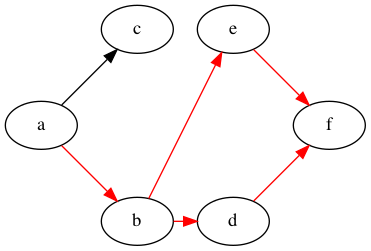

In [20]:
draw(mod_g(PWEVisualization.graphviz_from_meta_data(tc4_e1['pw_rel_dfs'], tc4_e1['meta_data']['graphviz'])), layout='neato')

The red edges are the ones that lie on some path/walk from 'a' to 'f'.

##### We can now add more edges to the original graph, and re-run the two queries (tc/2 and tc/4 + q/2).

In [21]:
%%dlv --donot-run --donot-display_input -lci g_e2

% Include/Exclude some edges:
e(c,d). e(c,e).

In [22]:
%dlv --run -l g_e1 g_e2 -exp e2 --donot-display_input

Output:


'{e(a,b), e(a,c), e(b,d), e(b,e), e(c,d), e(c,e), e(d,f), e(e,f)}'

In [23]:
e2['pw_rel_dfs'], e2['rel_schemas'], e2['pw_objects'] = load_worlds(e2['asp_soln'], e2['meta_data'], reasoner='dlv')

Number of Models: 1


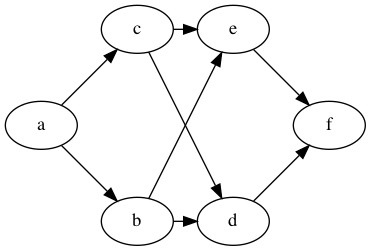

In [24]:
draw(mod_g(PWEVisualization.graphviz_from_meta_data(e2['pw_rel_dfs'], e2['meta_data']['graphviz'])), layout='neato')

The graph with the additional edges looks as above.

Running the tc/2 query on the graph.

In [25]:
%dlv --run -l g_e1 g_e2 tc -exp tc_e2 --donot-display_input

Output:


'{e(a,b), e(a,c), e(b,d), e(b,e), e(c,d), e(c,e), e(d,f), e(e,f), tc(a,b), tc(a,c), tc(a,d), tc(a,e), tc(a,f), tc(b,d), tc(b,e), tc(b,f), tc(c,d), tc(c,e), tc(c,f), tc(d,f), tc(e,f)}'

In [26]:
tc_e2['pw_rel_dfs'], tc_e2['rel_schemas'], tc_e2['pw_objects'] = load_worlds(tc_e2['asp_soln'], tc_e2['meta_data'], reasoner='dlv')

Number of Models: 1


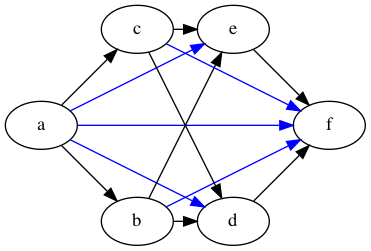

In [27]:
draw(mod_g(PWEVisualization.graphviz_from_meta_data(tc_e2['pw_rel_dfs'], tc_e2['meta_data']['graphviz'])), layout='neato')

As before, the blue edges are the tc/2 relations derived from the recursive case.

Running the tc/4 + q/2 query.

In [28]:
%dlv --run -l g_e1 g_e2 tc4 a_f_path_q -exp tc4_e2 --donot-display_input

Output:


'{e(a,b), e(a,c), e(b,d), e(b,e), e(c,d), e(c,e), e(d,f), e(e,f), tc4(a,b,a,b), tc4(a,c,a,c), tc4(a,d,a,b), tc4(a,d,a,c), tc4(a,d,b,d), tc4(a,d,c,d), tc4(a,e,a,b), tc4(a,e,a,c), tc4(a,e,b,e), tc4(a,e,c,e), tc4(a,f,a,b), tc4(a,f,a,c), tc4(a,f,b,d), tc4(a,f,b,e), tc4(a,f,c,d), tc4(a,f,c,e), tc4(a,f,d,f), tc4(a,f,e,f), tc4(b,d,b,d), tc4(b,e,b,e), tc4(b,f,b,d), tc4(b,f,b,e), tc4(b,f,d,f), tc4(b,f,e,f), tc4(c,d,c,d), tc4(c,e,c,e), tc4(c,f,c,d), tc4(c,f,c,e), tc4(c,f,d,f), tc4(c,f,e,f), tc4(d,f,d,f), tc4(e,f,e,f), q(a,b), q(a,c), q(b,d), q(b,e), q(c,d), q(c,e), q(d,f), q(e,f)}'

In [29]:
tc4_e2['pw_rel_dfs'], tc4_e2['rel_schemas'], tc4_e2['pw_objects'] = load_worlds(tc4_e2['asp_soln'], tc4_e2['meta_data'], reasoner='dlv')

Number of Models: 1


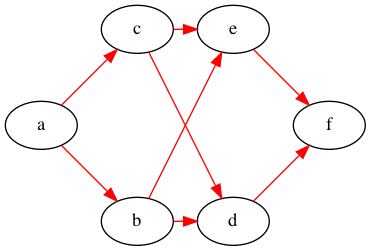

In [30]:
draw(mod_g(PWEVisualization.graphviz_from_meta_data(tc4_e2['pw_rel_dfs'], tc4_e2['meta_data']['graphviz'])), layout='neato')

Now, all the edges lie on some path/walk from 'a' to 'f'.

## Problem at Hand

We can use the above machinery to analyze workflow/dependency graphs.

#### Simple Di-Graph with two components

Suppose we know that components 'b' and 'c' depend on 'a' and that 'f' depends on 'd' and 'e'.

In [31]:
%%dlv --donot-run --donot-display_input -lci g_e3

% Now let's create some 

% graphviz graph graph_type=directed
% graphviz edge e(HEAD,TAIL) color=black ord=3

% Given edges: 
e(a,b).
e(a,c).
e(d,f).
e(e,f).

In [32]:
%dlv --run -l g_e3 -exp e3 --donot-display_input

Output:


'{e(a,b), e(a,c), e(d,f), e(e,f)}'

In [33]:
e3['pw_rel_dfs'], e3['rel_schemas'], e3['pw_objects'] = load_worlds(e3['asp_soln'], e3['meta_data'], reasoner='dlv')

Number of Models: 1


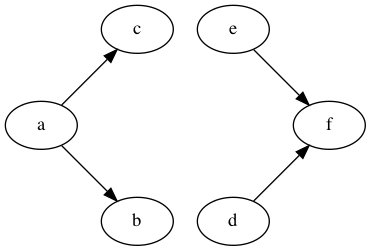

In [34]:
draw(mod_g(PWEVisualization.graphviz_from_meta_data(e3['pw_rel_dfs'], e3['meta_data']['graphviz'])), layout='neato')

However, let's say we want to analyze the "possible" ways, that 'f' can depend on 'a'. We use ASP and PWE to generate and analyze these possibilities.

#### Enlisting potential edge additions

To constraint the problem further, let's say that we can only add dependencies between nodes 'b', 'c', 'd' and 'e'.

In [35]:
%%dlv --donot-run --donot-display_input -lci gen_new_edges

% Which nodes All nodes: 
% n(X) :- e(X,_).
% n(X) :- e(_,X).
n(b). n(c). n(d). n(e). 
    
% Let's use a GENERATOR: For every pair of edges (X,Y) in a given set of nodes n/1,
% ... let's either have the edge "in" (= member of i/2) or "out" (= in o/2):
i(X,Y) v o(X,Y) :- n(X), n(Y), X!=Y. 

% Now let's use the same tc + provenance (= tc with 4 arguments) rules:

% First: let's copy all generated "in" pairs from i/2 to e/2: 
e(X,Y) :- i(X,Y).

Now, given this constraint, we generate the Possible Worlds (PWs).

In [36]:
%dlv -l g_e3 gen_new_edges --donot-display_input --donot-display_output -exp new_edges

In [37]:
#new_edges['pw_rel_dfs'], new_edges['rel_schemas'], new_edges['pw_objects'] = load_worlds(new_edges['asp_soln'], new_edges['meta_data'], reasoner='dlv')

The above cell has been commented out because it can take a long time to parse all the solutions. Since we are for now only interested in the number of PWs, we can do that using the simple "hack" below.

In [38]:
# Number of PWs
len(new_edges['asp_soln'].splitlines())

4096

As we can observe, this already generates 4096 possibilities.

Combinatorially, this makes sense.

4096 

= 2^12 i.e. for each of the 4*3 = 12 ordered pairs of nodes, we have 2 options, add it or don't 

= 4^6 i.e. for each of the (4 choose 2) = 6 pairs of nodes (x,y), we have 3 choices: add xy, add yx, add neither or add both)

In [39]:
# Uncomment the line below to see what the solution looks like.
# ASPRules("\n".join(new_edges['asp_soln'].splitlines()[:2]))

However, since this is a dependency graph, a dependency between two components can only occur in one direction. So we add this constraint as shown below.

In [40]:
%%dlv --donot-run --donot-display_input -lci remove_back_edges

% Let's also say that if an edge X,Y is "in", then the reverse edge Y,X cannot be in.
% This is just to show how one can easily add new constraints (reducing the set of PWs / solutions):
:- i(X,Y), i(Y,X).

Generating the PWs with the new constraint...

In [41]:
%dlv -l g_e3 remove_back_edges gen_new_edges --donot-display_input --donot-display_output -exp new_edges

In [42]:
#new_edges['pw_rel_dfs'], new_edges['rel_schemas'], new_edges['pw_objects'] = load_worlds(new_edges['asp_soln'], new_edges['meta_data'], reasoner='dlv')

The above cell has been commented out because it can take a long time to parse all the solutions. Since we are for now only interested in the number of PWs, we can do that using the simple "hack" below.

In [43]:
# Number of PWs
len(new_edges['asp_soln'].splitlines())

729

As we can see, we now have only 729 PWs (as opposed to the 4096 PWs earlier). This number also makes sense combinatorially.

729  = 3^6  i.e. for each of the (4 choose 2) = 6 unordered pairs of nodes (x,y), we have 3 choices: add xy, add yx or add neither)

In [44]:
# Uncomment the line below to see what the solution looks like.
# ASPRules("\n".join(new_edges['asp_soln'].splitlines()[:2]))

Now, we can generate the edges on paths/walks from 'a' to 'f' in these PWs.

In [45]:
%dlv -l g_e3 gen_new_edges remove_back_edges tc4 a_f_path_q --donot-display_input --donot-display_output -exp potential_graphs

In [46]:
potential_graphs['pw_rel_dfs'], potential_graphs['rel_schemas'], potential_graphs['pw_objects'] = load_worlds(potential_graphs['asp_soln'], potential_graphs['meta_data'], reasoner='dlv')

Number of Models: 729


In [47]:
ASPRules("\n".join(potential_graphs['asp_soln'].splitlines()[:2]))

'{n(b), n(c), n(d), n(e), e(a,b), e(a,c), e(d,f), e(e,f), tc4(a,b,a,b), tc4(a,c,a,c), tc4(d,f,d,f), tc4(e,f,e,f), i(b,c), o(b,d), o(b,e), o(c,b), o(c,d), i(c,e), i(d,b), i(d,c), o(d,e), i(e,b), o(e,c), i(e,d), e(b,c), e(c,e), e(d,b), e(d,c), e(e,b), e(e,d), tc4(b,c,b,c), tc4(c,e,c,e), tc4(d,b,d,b), tc4(d,c,d,c), tc4(e,b,e,b), tc4(e,d,e,d), tc4(c,f,d,f), tc4(e,f,d,f), tc4(b,f,d,f), tc4(c,f,e,f), tc4(d,f,e,f), tc4(b,f,e,f), tc4(a,c,b,c), tc4(d,c,b,c), tc4(e,c,b,c), tc4(c,c,b,c), tc4(a,e,c,e), tc4(d,e,c,e), tc4(e,e,c,e), tc4(b,e,c,e), tc4(c,b,d,b), tc4(e,b,d,b), tc4(b,b,d,b), tc4(c,c,d,c), tc4(e,c,d,c), tc4(b,c,d,c), tc4(c,b,e,b), tc4(d,b,e,b), tc4(b,b,e,b), tc4(c,d,e,d), tc4(d,d,e,d), tc4(b,d,e,d), tc4(a,b,d,b), tc4(a,f,e,f), tc4(a,f,d,f), tc4(a,d,e,d), tc4(a,b,e,b), tc4(a,c,d,c), tc4(e,f,e,d), tc4(c,f,c,e), tc4(a,c,a,b), tc4(d,c,d,b), tc4(e,c,e,b), tc4(a,d,a,b), tc4(d,d,d,b), tc4(e,d,e,b), tc4(a,e,a,b), tc4(d,e,d,b), tc4(e,e,e,b), tc4(a,b,a,c), tc4(d,b,d,c), tc4(b,b,b,c), tc4(a,d,a,c), tc4(d,d,d,c), tc4(b,d,b,c), tc4(a,e,a,c), tc4(d,e,d,c), tc4(b,e,b,c), tc4(e,b,e,d), tc4(e,c,e,d), tc4(e,e,e,d), tc4(c,b,c,e), tc4(c,c,c,e), tc4(c,d,c,e), tc4(a,b,b,c), tc4(a,e,b,c), tc4(a,d,b,c), tc4(a,f,c,e), tc4(a,d,c,e), tc4(a,c,c,e), tc4(a,b,c,e), tc4(b,f,c,e), tc4(b,d,c,e), tc4(b,c,c,e), tc4(b,b,c,e), tc4(b,b,d,c), tc4(b,e,d,c), tc4(b,e,d,b), tc4(b,d,d,c), tc4(b,d,d,b), tc4(b,c,d,b), tc4(b,e,e,d), tc4(b,e,e,b), tc4(b,f,e,d), tc4(b,d,e,b), tc4(b,c,e,d), tc4(b,c,e,b), tc4(b,b,e,d), tc4(c,b,b,c), tc4(c,e,b,c), tc4(c,d,b,c), tc4(c,b,d,c), tc4(c,e,d,c), tc4(c,e,d,b), tc4(c,d,d,c), tc4(c,d,d,b), tc4(c,c,d,b), tc4(c,e,e,d), tc4(c,e,e,b), tc4(c,f,e,d), tc4(c,d,e,b), tc4(c,c,e,d), tc4(c,c,e,b), tc4(c,b,e,d), tc4(d,b,b,c), tc4(d,e,b,c), tc4(d,d,b,c), tc4(d,f,c,e), tc4(d,d,c,e), tc4(d,c,c,e), tc4(d,b,c,e), tc4(d,e,e,d), tc4(d,e,e,b), tc4(d,f,e,d), tc4(d,d,e,b), tc4(d,c,e,d), tc4(d,c,e,b), tc4(d,b,e,d), tc4(e,b,b,c), tc4(e,e,b,c), tc4(e,d,b,c), tc4(e,f,c,e), tc4(e,d,c,e), tc4(e,c,c,e), tc4(e,b,c,e), tc4(e,b,d,c), tc4(e,e,d,c), tc4(e,e,d,b), tc4(e,d,d,c), tc4(e,d,d,b), tc4(e,c,d,b), tc4(a,f,a,b), tc4(d,f,d,b), tc4(e,f,e,b), tc4(a,f,a,c), tc4(d,f,d,c), tc4(b,f,b,c), tc4(a,b,d,c), tc4(a,b,e,d), tc4(a,c,d,b), tc4(a,c,e,b), tc4(a,c,e,d), tc4(a,d,d,b), tc4(a,d,d,c), tc4(a,d,e,b), tc4(a,f,b,c), tc4(a,f,e,d), tc4(a,e,d,b), tc4(a,e,d,c), tc4(a,e,e,b), tc4(a,e,e,d), tc4(b,f,d,c), tc4(b,f,d,b), tc4(b,f,e,b), tc4(c,f,b,c), tc4(c,f,d,c), tc4(c,f,d,b), tc4(c,f,e,b), tc4(d,f,b,c), tc4(d,f,e,b), tc4(e,f,b,c), tc4(e,f,d,c), tc4(e,f,d,b), tc4(a,f,e,b), tc4(a,f,d,c), tc4(a,f,d,b), q(e,b), q(d,c), q(d,b), q(e,d), q(b,c), q(e,f), q(d,f), q(a,b), q(a,c), q(c,e)}\n{n(b), n(c), n(d), n(e), e(a,b), e(a,c), e(d,f), e(e,f), tc4(a,b,a,b), tc4(a,c,a,c), tc4(d,f,d,f), tc4(e,f,e,f), i(b,c), o(b,d), o(b,e), o(c,b), i(c,d), i(c,e), i(d,b), o(d,c), o(d,e), i(e,b), o(e,c), i(e,d), e(b,c), e(c,d), e(c,e), e(d,b), e(e,b), e(e,d), tc4(b,c,b,c), tc4(c,d,c,d), tc4(c,e,c,e), tc4(d,b,d,b), tc4(e,b,e,b), tc4(e,d,e,d), tc4(c,f,d,f), tc4(e,f,d,f), tc4(b,f,d,f), tc4(c,f,e,f), tc4(d,f,e,f), tc4(b,f,e,f), tc4(a,c,b,c), tc4(d,c,b,c), tc4(e,c,b,c), tc4(c,c,b,c), tc4(a,d,c,d), tc4(d,d,c,d), tc4(e,d,c,d), tc4(b,d,c,d), tc4(a,e,c,e), tc4(d,e,c,e), tc4(e,e,c,e), tc4(b,e,c,e), tc4(c,b,d,b), tc4(e,b,d,b), tc4(b,b,d,b), tc4(c,b,e,b), tc4(d,b,e,b), tc4(b,b,e,b), tc4(c,d,e,d), tc4(d,d,e,d), tc4(b,d,e,d), tc4(a,b,d,b), tc4(a,f,e,f), tc4(a,f,d,f), tc4(a,d,e,d), tc4(a,b,e,b), tc4(c,f,c,d), tc4(e,f,e,d), tc4(c,f,c,e), tc4(a,c,a,b), tc4(d,c,d,b), tc4(e,c,e,b), tc4(a,d,a,b), tc4(d,d,d,b), tc4(e,d,e,b), tc4(a,e,a,b), tc4(d,e,d,b), tc4(e,e,e,b), tc4(a,b,a,c), tc4(b,b,b,c), tc4(a,d,a,c), tc4(b,d,b,c), tc4(a,e,a,c), tc4(b,e,b,c), tc4(c,b,c,d), tc4(e,b,e,d), tc4(c,c,c,d), tc4(e,c,e,d), tc4(c,e,c,d), tc4(e,e,e,d), tc4(c,b,c,e), tc4(c,c,c,e), tc4(c,d,c,e), tc4(a,b,b,c), tc4(a,e,b,c), tc4(a,d,b,c), tc4(a,b,c,d), tc4(a,e,c,d), tc4(a,f,c,e), tc4(a,f,c,d), tc4(a,d,c,e), tc4(a,c,c,e), tc4(a,c,c,d), tc4(a,b,c,e), tc4(b,b,c,d), tc

Preview of the first 2 PWs. Hard to read and interpret.

### Interested in unique a --> f path sets

We know these are recorded in the q/2 relation as we defined earlier. However, we want to be able to find some patterns or clusters within these to be able to better analyze them. We can use a distance metric to do this. In this case, a simple distance metric, measuring the number of elements in the symmetric difference between the two sets' q/2 relations.

For a taste, this is what the symmetric difference looks like for PWs 1 and 2.

In [48]:
PWEQuery.difference_both_ways(dfs=potential_graphs['pw_rel_dfs'], 
                              rl_name='q_2', pw_id_1=1, pw_id_2=2, do_print=False)

,x1,x2
0,d,c
1,c,d


As we can see, one of them has the edge d-->c while the other has the edge c-->d.

Similarly for PWs 1 and 100:

In [49]:
PWEQuery.difference_both_ways(dfs=potential_graphs['pw_rel_dfs'], rl_name='q_2', pw_id_1=1, pw_id_2=100, do_print=False)

,x1,x2
0,e,b
1,d,c
2,d,b
3,b,c
4,a,b


We can construct a distance matrix of the PWs using this metric.

In [50]:
# n = len(potential_graphs['pw_objects'])
# dist_matrix = np.zeros((n,n))
# for i in range(n):
#     for j in range(i+1, n):
#         dist_matrix[i][j] = dist_matrix[j][i] = len(PWEQuery.difference_both_ways(dfs=potential_graphs['pw_rel_dfs'], 
#                                                                                   rl_name='q_2', 
#                                                                                   do_print=False, 
#                                                                                   pw_id_1=i+1, 
#                                                                                   pw_id_2=j+1))
# dist_matrix

This naive (but well-defined) way takes too long, so we do an equivalent version below, optimized for this particular problem

In [51]:
def get_pw_q_rels(q_2_df, pw_id):
    pw_q_2_df = q_2_df[q_2_df['pw'] == pw_id]
    pw_q_rels = []
    for i, row in pw_q_2_df.iterrows():
        pw_q_rels.append((row['x1'], row['x2']))
    return set(pw_q_rels)

def compare_q_sets(pw_1_q_set, pw_2_q_set):
    return len(pw_1_q_set-pw_2_q_set) + len(pw_2_q_set-pw_1_q_set)

def get_q_set_dist_matrix(exp):
    n = len(exp['pw_objects'])
    dist_matrix = np.zeros((n,n))
    q_2_df = exp['pw_rel_dfs']['q_2']
    q_sets = list(map(lambda pw_id: get_pw_q_rels(q_2_df, pw_id), range(1, n+1)))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i][j] = dist_matrix[j][i] = compare_q_sets(q_sets[i], q_sets[j])
    return dist_matrix

In [52]:
dist_matrix = get_q_set_dist_matrix(potential_graphs)
dist_matrix

array([[0., 2., 1., ..., 9., 9., 9.],
       [2., 0., 1., ..., 9., 9., 9.],
       [1., 1., 0., ..., 8., 8., 8.],
       ...,
       [9., 9., 8., ..., 0., 0., 0.],
       [9., 9., 8., ..., 0., 0., 0.],
       [9., 9., 8., ..., 0., 0., 0.]])

Now we try to make sense of this using several clustering techniques at our disposal.

/anaconda3/envs/LeanEuler-prod-env/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


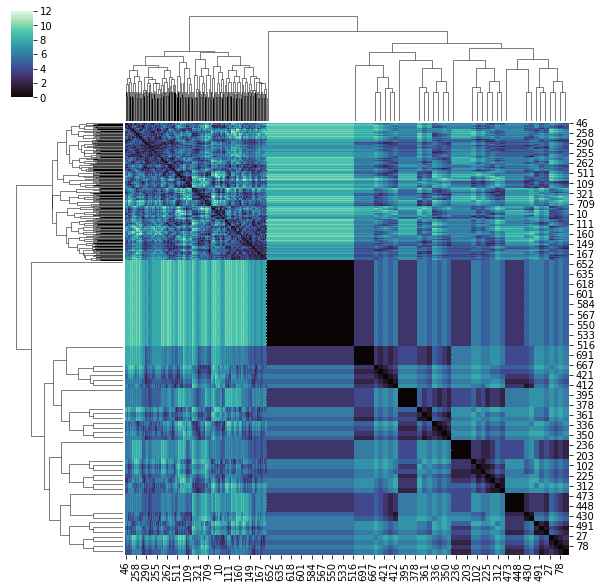

In [53]:
_ = PWEVisualization.cluster_map_viz(dist_matrix)

There seem to be some structure to these PWs. There seems to be a big group of equivalent PWs as evident by the large black square in the middle. There also seem to be a lot of smaller sets of equivalent solutions as evident by the small black squares in the bottom right. The rest seem to be groups of their own.

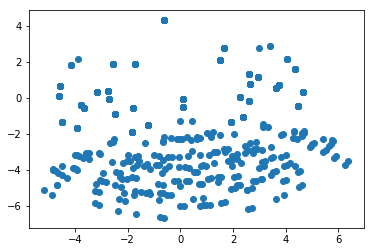

In [54]:
_ = PWEVisualization.mds_sklearn(dist_matrix)

Hard to make much sense of the Multi-Dimensional Scaling (MDS) output. Perhaps it is not particularly suited to analyze this problem.

All the visualizations so far are very pretty, but hard to interpret.

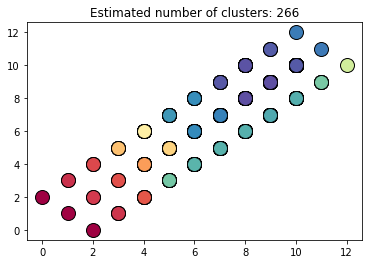

In [55]:
_ = PWEVisualization.dbscan_clustering(dist_matrix)

This gives us something interesting. It says there are 266 unique clusters or groups. Let's see if we can't find these.

These are probably just the unique sets of q/2 relations themselves. Let's see if that's true.

In [56]:
def get_q_2_groups(exp):
    groups = {}
    n = len(exp['pw_objects'])
    q_2_df = exp['pw_rel_dfs']['q_2']
    for pw_id in range(1, n+1):
        pw_q_2_df = q_2_df[q_2_df['pw'] == pw_id]
        pw_q_rels = []
        for i, row in pw_q_2_df.iterrows():
            pw_q_rels.append((row['x1'], row['x2']))
        pw_q_rels = frozenset(pw_q_rels)
        if pw_q_rels not in groups:
            groups[pw_q_rels] = []
        groups[pw_q_rels].append(pw_id)
    return groups

In [57]:
groups = get_q_2_groups(potential_graphs)

In [58]:
len(groups.keys())

266

Voila! Now, let's visualize these.

In [59]:
vizs = get_vizs(potential_graphs, groups)

In [60]:
# Uncomment the line below to re-write the visualizations.
# save_vizs(vizs, 'Vizs')

Some notable ones are:

Group 253: 144 ways to add 0 or more edges such that there are no paths/walks from 'a' to 'f', and hence no dependency.

Group 265: Looking at these makes two things clear. We are currently capturing 'walks' and not 'paths'. Secondly, and more importantly, there are cycles within the generated PWs. Let's remove the PWs with cycles.

Note: The group numbers above might change on re-execution.

#### Removing Cycles

Removing cycles is a simple operation in ASP, given that we already have the tc/4 query.

In [61]:
%%dlv --donot-run --donot-display_input -lci remove_cycles


% nn(A) :- e(A,_).
% nn(A) :- e(_,A).
nn(a). nn(b). nn(c). nn(d). nn(e). nn(f).

% It must not be the case that A can reach B AND B can reach A, else there'd be a cycle.
:- tc4(A,B,_,_), tc4(B,A,_,_), nn(A), nn(B).

Now, we re-run the experiment with this additional constraint.

In [62]:
%dlv -l g_e3 gen_new_edges remove_back_edges remove_cycles tc4 a_f_path_q --donot-display_input --donot-display_output -exp potential_graphs_no_cycles

In [63]:
len(potential_graphs_no_cycles['asp_soln'].splitlines())

543

In [64]:
potential_graphs_no_cycles['pw_rel_dfs'], potential_graphs_no_cycles['rel_schemas'], potential_graphs_no_cycles['pw_objects'] = load_worlds(potential_graphs_no_cycles['asp_soln'], potential_graphs_no_cycles['meta_data'], reasoner='dlv')

Number of Models: 543


As we can see, this time around we only have 543 PWs. Now let's see if we can group them as we did earlier.

In [65]:
groups_no_cycle = get_q_2_groups(potential_graphs_no_cycles)

In [66]:
len(groups_no_cycle.keys())

136

We can! Only 136 unique ways. Lot fewer than the 4096 PWs we started off with.

For a sanity check, we can confirm this using the DBScan Algorithm using the same distance metric as earlier.

In [67]:
dist_matrix = get_q_set_dist_matrix(potential_graphs_no_cycles)
dist_matrix

array([[0., 1., 1., ..., 7., 7., 7.],
       [1., 0., 2., ..., 8., 8., 8.],
       [1., 2., 0., ..., 6., 6., 6.],
       ...,
       [7., 8., 6., ..., 0., 0., 0.],
       [7., 8., 6., ..., 0., 0., 0.],
       [7., 8., 6., ..., 0., 0., 0.]])

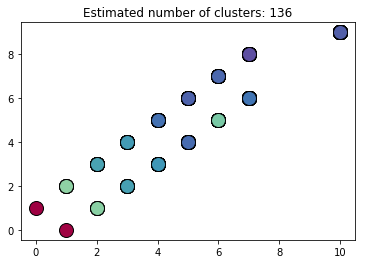

In [68]:
_ = PWEVisualization.dbscan_clustering(dist_matrix)

It checks out!

Also as a sanity check, we want to ensure that the new groups (without cycles) are a subset of the groups with cycles.

In [69]:
set(groups.keys()) >= set(groups_no_cycle.keys())

True

This checks out too.

Now we generate visualizations of these 136 groups.

In [70]:
vizs_no_cycles = get_vizs(potential_graphs_no_cycles, groups_no_cycle)

In [71]:
# Uncomment the line below to re-write the visualizations.
# save_vizs(vizs_no_cycles, 'Vizs_no_cycles')